In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    """
    Trace une série temporelle.

    :param time: Array de temps, représente les points temporels de la série.
    :param series: Array de valeurs, les données de la série temporelle.
    :param format: String, le style de la ligne du graphique.
    :param start: Int, index de début pour le tracé.
    :param end: Int, index de fin pour le tracé.
    :param label: String, légende pour la série dans le graphique.
    """
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# Tendance et saisonnalité

In [3]:
# Une fonction trend (tendance) qui dépend du temps et qui a une pente par défaut = 0
def trend(time, slope=0):
    """
    Crée une tendance linéaire pour une série temporelle.

    :param time: Array de temps, représentant les points temporels.
    :param slope: Float, la pente de la tendance linéaire.
    :return: Array, les valeurs de la tendance à chaque point temporel.
    """
    return slope * time



Créons une série temporelle dont la tendance est à la hausse uniquement:




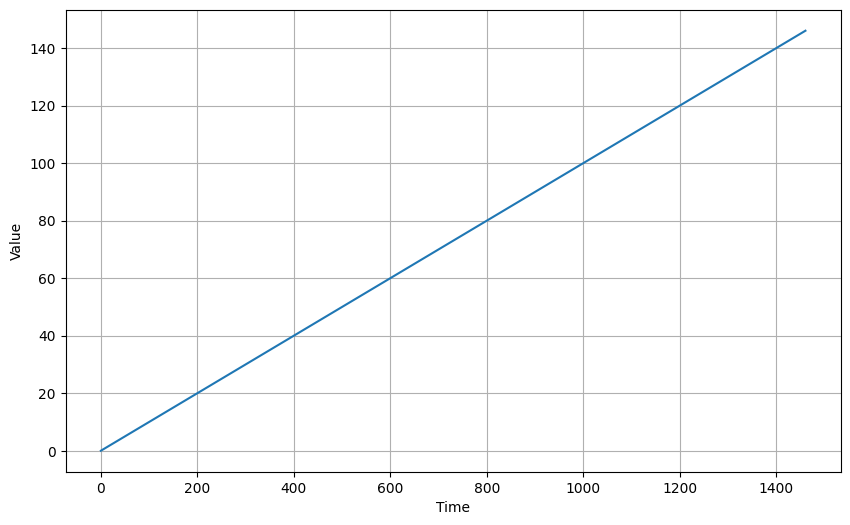

In [4]:
# 4 ans
time = np.arange(4 * 365 + 1)
baseline = 10
series = trend(time, 0.1)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Générons, maintenant, une série temporelle avec un modèle saisonnier :

In [5]:
def seasonal_pattern(season_time):
    """Juste un pattern arbitraire, qu'on peut changer par ce que l'on veut"""

    """
    Définit un motif saisonnier.

    :param season_time: Array, partie fractionnaire de la période saisonnière.
    :return: Array, valeurs du motif saisonnier.
    """
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))



def seasonality(time, period, amplitude=1, phase=0):
    """Repéter le même pattern à chaque période"""
    """
    Ajoute une saisonnalité à la série temporelle.

    :param time: Array de temps.
    :param period: Int, durée d'une période saisonnière.
    :param amplitude: Float, amplitude du motif saisonnier.
    :param phase: Float, décalage de phase dans le motif saisonnier.
    :return: Array, valeurs saisonnières ajoutées à chaque point temporel.
    """
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

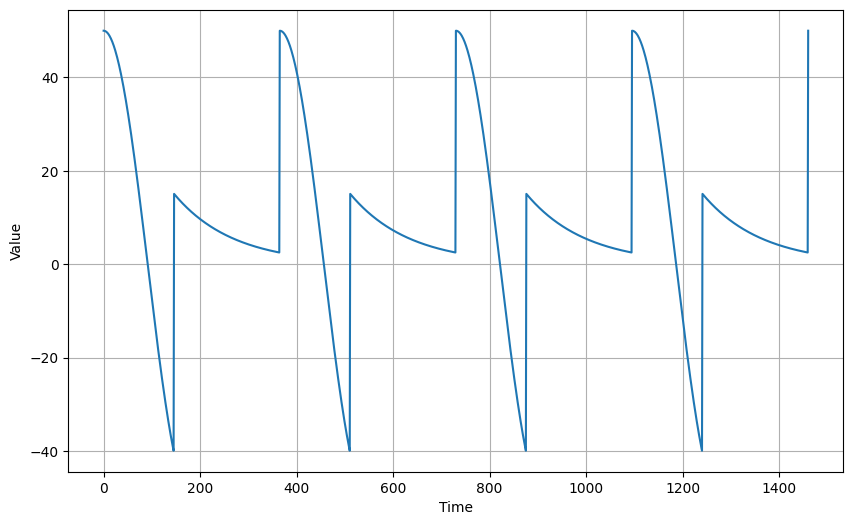

In [6]:
baseline = 10
amplitude = 50
series = seasonality(time, period=365, amplitude=amplitude)
####
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Créons maintenant une série temporelle avec à la fois tendance et saisonnalité

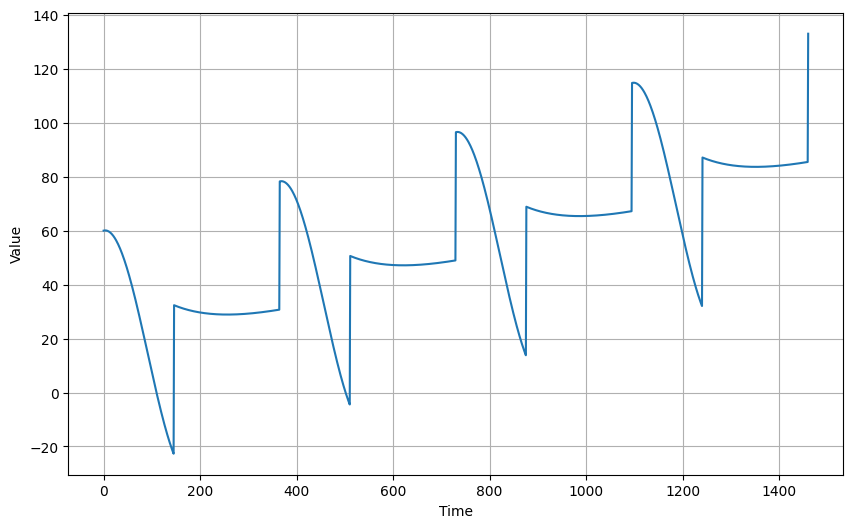

In [7]:
slope = 0.05
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

# Le bruit (Noise)

En pratique, peu de séries temporelles réelles ont un signal fluide. Elles présentent généralement un bruit et le rapport signal sur bruit peut parfois être très faible.

Générons un bruit blanc:

In [8]:
def white_noise(time, noise_level=1, seed=None):
    """
    Génère un bruit blanc pour la série temporelle.

    :param time: Array de temps.
    :param noise_level: Float, intensité du bruit.
    :param seed: Int, graine pour la génération aléatoire, pour la reproductibilité.
    :return: Array, valeurs de bruit pour chaque point temporel.
    """
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

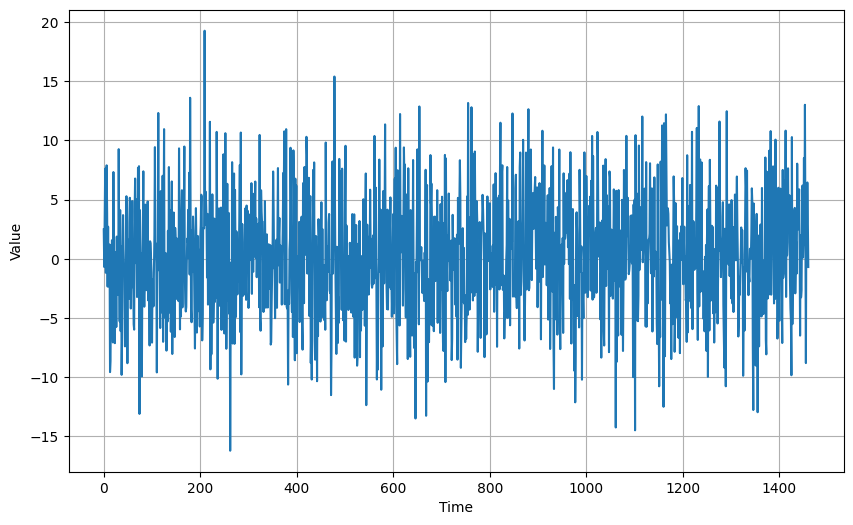

In [9]:
noise_level = 5
noise = white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, noise)
plt.show()

Ajoutons maintenant ce bruit blanc à la série temporelle :

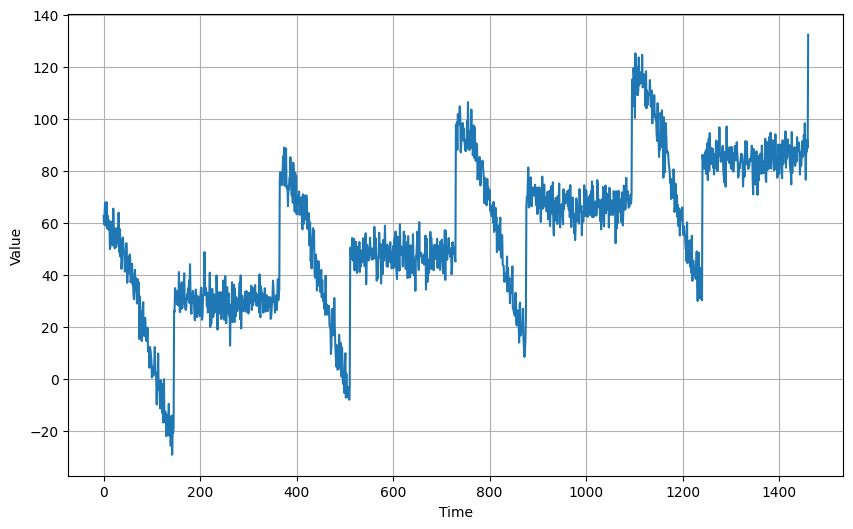

In [10]:
series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Cela semble assez réaliste pour le moment. Essayons de le prévoir.

Nous le diviserons en deux périodes :


*   la période de formation
et
*   la période de validation

*   Rq: Dans de nombreux cas, vous voudriez également avoir une période de test.
La division sera au pas de temps convenable.

In [11]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

Dans ce passage du notebook, on aborde une étape cruciale dans l'analyse des séries temporelles : la prévision. On divise notre série temporelle en deux ensembles distincts, la période de formation (ou d'entraînement) et la période de validation, et l'on introduit le concept d'autocorrélation. Voici une explication détaillée :

### Division de la Série Temporelle
1. **Split Time** :
   - `split_time = 1000` : On définit un point de division (`split_time`) pour séparer lae série temporelle. Ici, on a choisit 1000 comme point de séparation, ce qui signifie que toutes les données avant le pas de temps 1000 seront utilisées pour l'entraînement, et celles après pour la validation.

2. **Période de Formation (Training Period)** :
   - `time_train = time[:split_time]`
   - `x_train = series[:split_time]`
   - Ces lignes définissent la période d'entraînement. On utilise les données jusqu'au point de division (`split_time`) pour entraîner le modèle.

3. **Période de Validation (Validation Period)** :
   - `time_valid = time[split_time:]`
   - `x_valid = series[split_time:]`
   - Ces lignes définissent la période de validation. Les données après le point de division sont réservées pour tester la performance du modèle.



### Introduction à l'Autocorrélation
1. **Fonction `autocorrelation`** :
   - On crée une série temporelle avec une autocorrélation définie. L'autocorrélation est une relation dans laquelle une série est corrélée avec elle-même à des intervalles de temps antérieurs.

2. **Paramètres de l'Autocorrélation** :
   - `rnd = np.random.RandomState(seed)` : Générateur de nombres aléatoires pour la reproductibilité.
   - `φ1 = 0.5` et `φ2 = -0.1` : Coefficients définissant la relation entre le temps actuel et les pas de temps précédents.
   - La boucle for crée la série autocorrélée en utilisant ces coefficients.

3. **Génération de la Série Temporelle Autocorrélée** :
   - `series = autocorrelation(time, 10, seed=42)`: On génére une nouvelle série temporelle avec une structure autocorrélée.

4. **Tracé de la Série Autocorrélée** :
   - Enfin, On trace les premiers 200 points de cette série autocorrélée pour visualiser sa nature.

### But de cette Section
- **Prévision** : En créant une série temporelle autocorrélée et en la divisant en périodes de formation et de validation, on met en place le terrain pour développer et évaluer des modèles de prévision.
- **Comprendre l'Autocorrélation** : La compréhension de l'autocorrélation est essentielle dans la modélisation des séries temporelles, car elle affecte la manière dont les modèles prédisent les valeurs futures basées sur les données passées.

Cette section du notebook est donc une introduction à la préparation des données pour la modélisation prédictive et à la compréhension des concepts importants comme l'autocorrélation dans les séries temporelles.

In [12]:
def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ1 = 0.5
    φ2 = -0.1
    ar = rnd.randn(len(time) + 50)
    ar[:50] = 100
    for step in range(50, len(time) + 50):
        ar[step] += φ1 * ar[step - 50]
        ar[step] += φ2 * ar[step - 33]
    return ar[50:] * amplitude

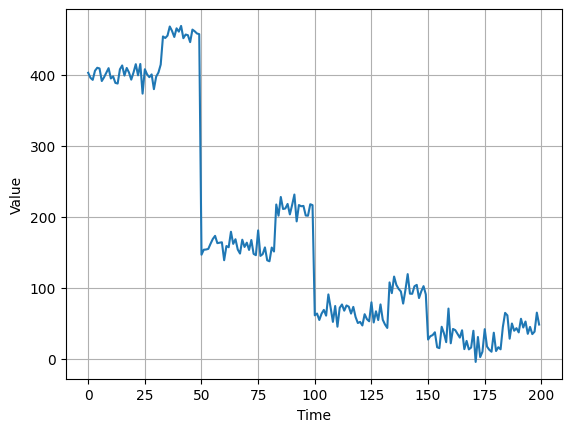

In [13]:
series = autocorrelation(time, 10, seed=42)
plot_series(time[:200], series[:200])
plt.show()

################
################
################
################

In [ ]:
def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ = 0.8
    ar = rnd.randn(len(time) + 1)

    for step in range(1, len(time) + 1):
        ar[step] += φ * ar[step - 1]
    return ar[1:] * amplitude

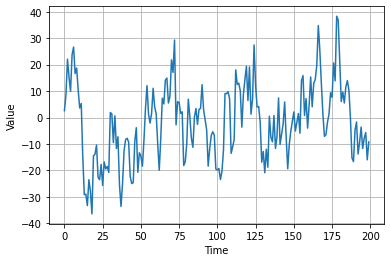

In [ ]:
series = autocorrelation(time, 10, seed=42)
plot_series(time[:200], series[:200])

plt.show()

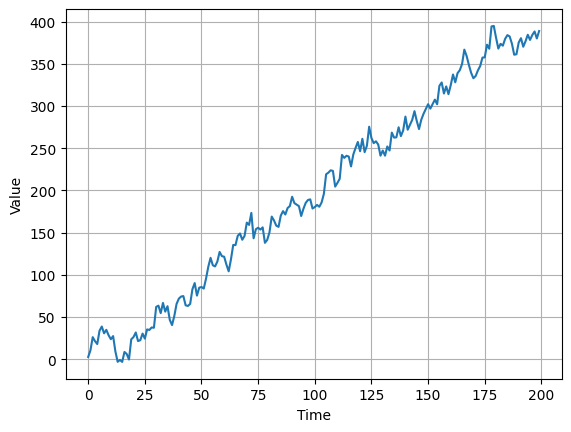

In [ ]:
series = autocorrelation(time, 10, seed=42) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

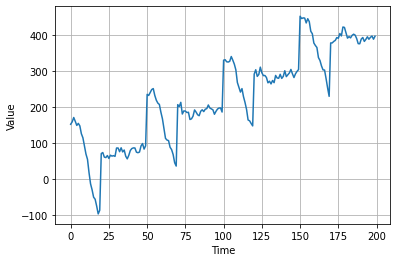

In [ ]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

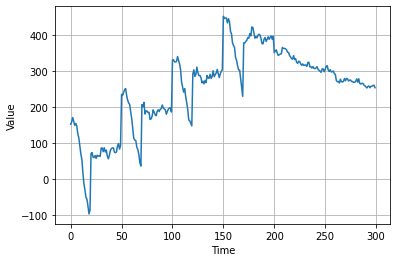

In [ ]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
series2 = autocorrelation(time, 5, seed=42) + seasonality(time, period=50, amplitude=2) + trend(time, -1) + 550
series[200:] = series2[200:]
#series += noise(time, 30)
plot_series(time[:300], series[:300])
#plot_series(time[:300], series2[:300])
plt.show()

In [ ]:
def impulses(time, num_impulses, amplitude=1, seed=None):
    rnd = np.random.RandomState(seed)
    impulse_indices = rnd.randint(len(time), size=10)
    series = np.zeros(len(time))
    for index in impulse_indices:
        series[index] += rnd.rand() * amplitude
    return series

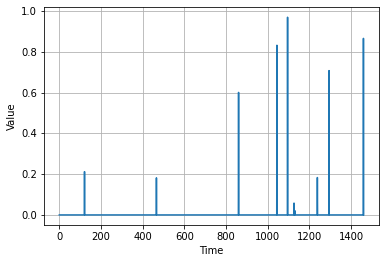

In [ ]:
series = impulses(time, 10, seed=42)
plot_series(time, series)
plt.show()

In [ ]:
def autocorrelation(source, φs):
    ar = source.copy()
    max_lag = len(φs)
    for step, value in enumerate(source):
        for lag, φ in φs.items():
            if step - lag > 0:
              ar[step] += φ * ar[step - lag]
    return ar

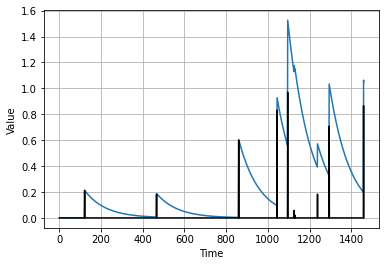

In [ ]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.99})
plot_series(time, series)
plt.plot(time, signal,"k-")
plt.show()

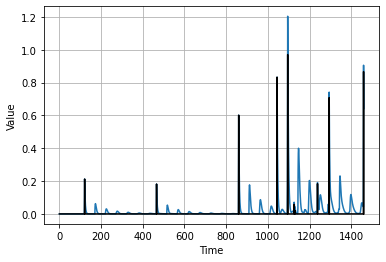

In [ ]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.70, 50: 0.2})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

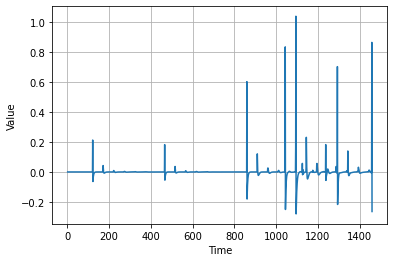

In [ ]:
series_diff1 = series[1:] - series[:-1]
plot_series(time[1:], series_diff1)


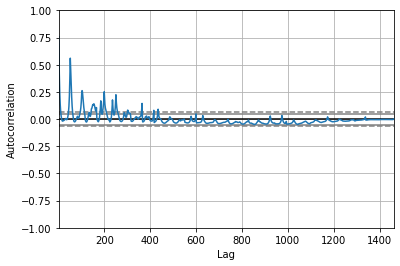

In [ ]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                                      ARIMA Model Results                                      
Dep. Variable:     D.Monthly Mean Total Sunspot Number   No. Observations:                 3234
Model:                                  ARIMA(5, 1, 0)   Log Likelihood              -15032.204
Method:                                        css-mle   S.D. of innovations             25.259
Date:                                 Tue, 22 Nov 2022   AIC                          30078.408
Time:                                         17:56:12   BIC                          30120.979
Sample:                                     02-28-1749   HQIC                         30093.662
                                          - 07-31-2018                                         
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const       

In [ ]:
# Sunspots.csv
!gdown --id 1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5
To: /content/Sunspots.csv
100% 70.8k/70.8k [00:00<00:00, 70.1MB/s]


In [ ]:
import pandas as pd

df = pd.read_csv('./Sunspots.csv', parse_dates=["Date"], index_col="Date")
series = df["Monthly Mean Total Sunspot Number"].asfreq("1M")
series.head()

Date
1749-01-31     96.7
1749-02-28    104.3
1749-03-31    116.7
1749-04-30     92.8
1749-05-31    141.7
Freq: M, Name: Monthly Mean Total Sunspot Number, dtype: float64

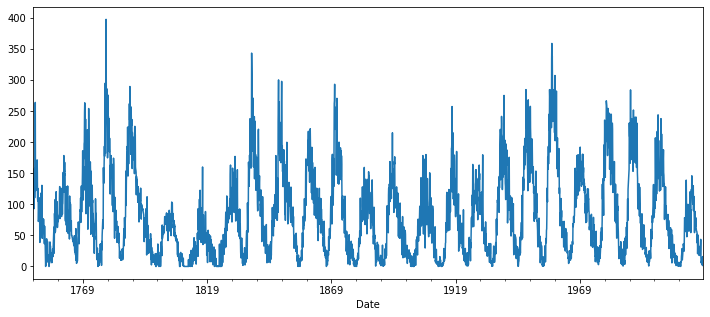

In [ ]:
series.plot(figsize=(12, 5))

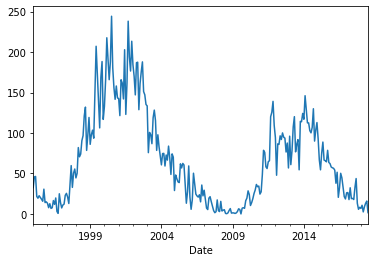

In [ ]:
series["1995-01-01":].plot()

(0.0, 100.0, -50.0, 50.0)

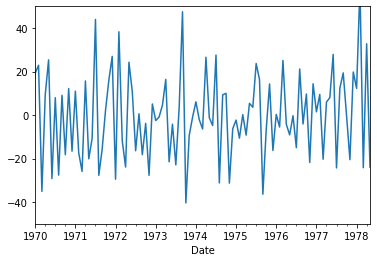

In [ ]:
series.diff(1).plot()
plt.axis([0, 100, -50, 50])

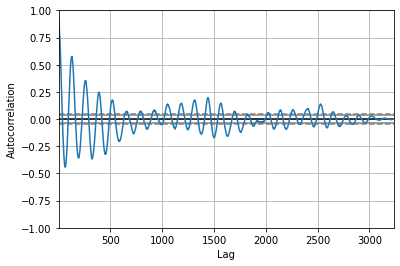

In [ ]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)

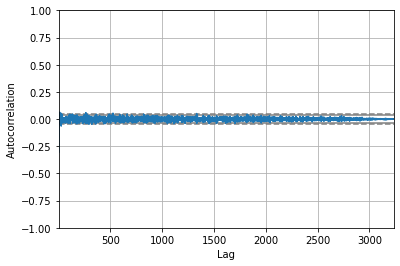

In [ ]:
autocorrelation_plot(series.diff(1)[1:])

(0.0, 500.0, -0.1, 0.1)

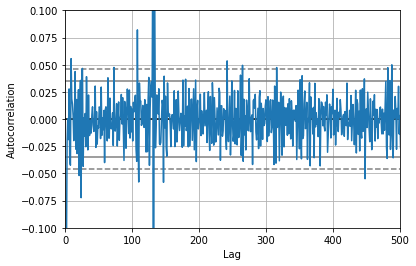

In [ ]:
autocorrelation_plot(series.diff(1)[1:].diff(11 * 12)[11*12+1:])
plt.axis([0, 500, -0.1, 0.1])

(0.0, 50.0, -0.1, 0.1)

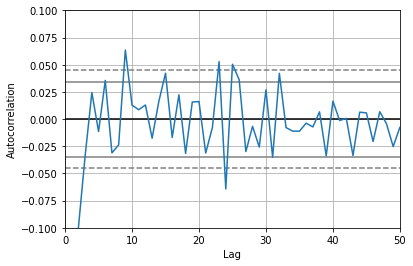

In [ ]:
autocorrelation_plot(series.diff(1)[1:])
plt.axis([0, 50, -0.1, 0.1])

In [ ]:
116.7 - 104.3

12.400000000000006

In [ ]:
[series.autocorr(lag) for lag in range(1, 50)]

[0.9173241872367174,
 0.8847544206843755,
 0.868599123137202,
 0.8579945644357173,
 0.8433856340533112,
 0.8306731729540908,
 0.8121138897370149,
 0.7986059878541056,
 0.7890399489112041,
 0.7689560950230403,
 0.7474788716472306,
 0.7238791854325145,
 0.6980482665379879,
 0.6751408790165827,
 0.6495670049994807,
 0.6170092179855494,
 0.5872028494447984,
 0.5537209387574675,
 0.5254318210710769,
 0.49453915657274083,
 0.4609225001523783,
 0.4325062022560218,
 0.4054329883610248,
 0.36959289593532285,
 0.3443549899460771,
 0.3106967622634346,
 0.2711411693399097,
 0.23646964014948227,
 0.20297806535027266,
 0.17379537689762675,
 0.14010793836897956,
 0.11227445177460688,
 0.07751076852866026,
 0.044054957960606746,
 0.012510863120931944,
 -0.017282156504566333,
 -0.046433352357512225,
 -0.07440203532677167,
 -0.10339501296715731,
 -0.12680806162977237,
 -0.1530928264197593,
 -0.17906178224521474,
 -0.20506772757843425,
 -0.22530867957591932,
 -0.2466587000579558,
 -0.26904607854968615,
 

In [ ]:
#Read a comma-separated values (csv) file into DataFrame.
pd.read_csv('./Sunspots.csv', sep=',', delimiter=None, header='infer', names=None,
            index_col=None, usecols=None, squeeze=False, prefix=None, mangle_dupe_cols=True,
            dtype=None, engine=None, converters=None, true_values=None, false_values=None,
            skipinitialspace=False, skiprows=None, skipfooter=0, nrows=None, na_values=None,
            keep_default_na=True, na_filter=True, verbose=False, skip_blank_lines=True, parse_dates=False,
            infer_datetime_format=False, keep_date_col=False, date_parser=None, dayfirst=False, iterator=False,
            chunksize=None, compression='infer', thousands=None, decimal=b'.', lineterminator=None, quotechar='"',
            quoting=0, doublequote=True, escapechar=None, comment=None, encoding=None, dialect=None,
            error_bad_lines=True, warn_bad_lines=True, delim_whitespace=False,
            low_memory=True, memory_map=False, float_precision=None)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7
...,...,...,...
3230,3230,2018-03-31,2.5
3231,3231,2018-04-30,8.9
3232,3232,2018-05-31,13.2
3233,3233,2018-06-30,15.9


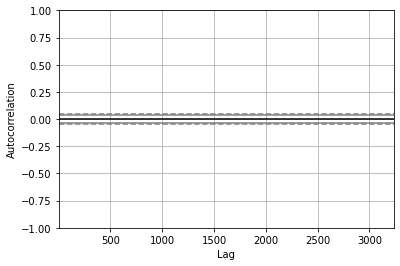

In [ ]:
from pandas.plotting import autocorrelation_plot

series_diff = series
for lag in range(50):
  series_diff = series_diff[1:] - series_diff[:-1]

autocorrelation_plot(series_diff)

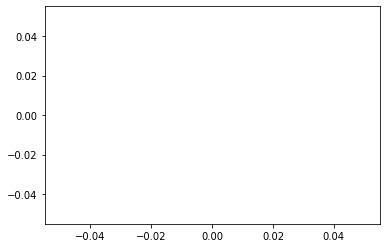

In [ ]:
series_diff1 = pd.Series(series[1:] - series[:-1])
autocorrs = [series_diff1.autocorr(lag) for lag in range(1, 60)]
plt.plot(autocorrs)
plt.show()